# Оптимизация маркетинговых затрат Яндекс.Афиши. 

В нашем распоряжении имеются данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:

 -лог сервера с данными о посещениях сайта Яндекс.Афиши,
    
 -выгрузка всех заказов за этот период,
    
 -статистика рекламных расходов.


Цель проекта исследовать:

 -как клиенты пользуются сервисом,
 
 -когда делают первые покупки на сайте,
 
 -сколько денег приносит компании каждый клиент,
 
 -когда расходы на привлечение клиента окупаются.



###  Изучение и подготовка общей информации. 

Импортируем данные и создадим DateFrame. Изучим общую информацию в таблицах и проверим корректность данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab
import plotly.graph_objects as go
import plotly.express  as  px

In [2]:
# откроем файлы с данными 

server_path = '/datasets/visits_log.csv'
filename = 'visits_log.csv'
try:
    visits = pd.read_csv(server_path)
except:
    visits = pd.read_csv(filename)
    
server_path = '/datasets/orders_log.csv'
filename = 'orders_log.csv'
try:
    orders = pd.read_csv(server_path)
except:
    orders = pd.read_csv(filename)
    
server_path = '/datasets/costs.csv'
filename = 'costs.csv'
try:
    costs = pd.read_csv(server_path)
except:
    costs = pd.read_csv(filename)

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Таблица **visits** содержит пять столбцов с информацией:

**Device** — категория устройства пользователя (тип object)

**End Ts** — дата и время окончания сессии (тип object)

**Source Id** - идентификатор источника перехода на сайт (тип int64)

**Start Ts** — дата и время начала сессии (тип object)

**Uid** — уникальный идентификатор пользователя (тип uint64)

Пропущенных данных в таблице нет. В столбцах **End Ts** и **Start Ts** содержтся данные о дате и времени, а тип данных object. Во всех названиях столбцов содержатся буквы разного регистра, что может создать некоторые неудобства при дальнейшей обработке. 


In [5]:
# Изменим названия столбцов 
visits.rename(columns = lambda x: x.replace('Start Ts','Start_Ts'), inplace=True)
visits.rename(columns = lambda x: x.replace('End Ts','End_Ts'), inplace=True)
visits.rename(columns = lambda x: x.replace('Source Id','Source_Id'), inplace=True)

In [6]:
# приведем все названия к нижнему регистру, используя метод lower(). 
visits.columns = [x.lower() for x in visits.columns]
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [8]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Таблица **orders** содержит три столбца с информацией:

**Buy Ts** — дата и время заказа (тип object)

**Revenue** - сумма заказа (тип float64)

**Uid** — уникальный идентификатор пользователя (тип uint64)

Пропущенных данных в таблице нет. В столбце Buy Ts содержтся данные о дате и времени, а тип данных object. Во всех названиях столбцов содержатся буквы разного регистра, что может создать некоторые неудобства при дальнейшей обработке.

In [11]:
# Изменим названия столбцов 
orders.rename(columns = lambda x: x.replace('Buy Ts','Buy_Ts'), inplace=True)

In [12]:
# приведем все названия к нижнему регистру, используя метод lower(). 
orders.columns = [x.lower() for x in orders.columns]
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица **costs** содержит три столбца с информацией:

**source_id** — идентификатор рекламного источника (тип int64)

**dt** - дата проведения рекламной кампании (тип object)

**costs** — расходы на проведение рекламной кампании (тип float64)

Пропущенных данных в таблице нет. В столбце **dt** содержтся данные о дате и времени, а тип данных object. Во всех названиях столбцов содержатся буквы одинакового регистра, замену регистра производить не нужно.

In [16]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Проведем проверку данных на наличие дубликатов, используя метод duplicated()

In [17]:
print('Количество дубликатов в таблице visits:', visits.duplicated().sum())
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())
print('Количество дубликатов в таблице costs:', costs.duplicated().sum())

Количество дубликатов в таблице visits: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице costs: 0


#### Вывод 

Предоставленные таблицы с пользовательскими данными с информацией о посещениях сайта, покупках и затратах на маркетинг. Все таблицы корректно загружены, пропусков не обнаружено. Преобразованы названия полей, а также приведены типы данных, проведена проверка на наличие дубликатов - дубликатов нет. 

### Расчет метрик и построение графиков.

У нас есть данные о визитах пользователей на портал Яндекс.Афиши. Попробуем оценить общую активность пользователей. Посмотрим, сколько людей пользуются сайтом в день, в неделю, в месяц. Определим, сколько в среднем сессий за день, а также среднюю длительность пользовательской сессии.

#### Продуктовые метрики.

##### Рассчитаеvм DAU, WAU и MAU. Вычислим средние значения этих метрик за весь период. Отобразим изменения метрик во времени на графиках.

Посмотрим на данные о визитах пользователей в трех измерених:

DAU — количество уникальных пользователей в день

WAU — количество уникальных пользователей в неделю

MAU — количество уникальных пользователей в месяц

In [18]:
# Выделим в отдельный столбец месяц, неделю и день начала сессии
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_day'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [19]:
mau = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()
dau = visits.groupby('session_day').agg({'uid':'nunique'}).mean()
print("MAU = {:.0f} — количество уникальных пользователей в месяц".format(mau['uid']))
print("WAU = {:.0f} — количество уникальных пользователей в неделю".format(wau['uid']))
print("DAU = {:.0f} — количество уникальных пользователей в день".format(dau['uid']))

MAU = 23228 — количество уникальных пользователей в месяц
WAU = 5716 — количество уникальных пользователей в неделю
DAU = 908 — количество уникальных пользователей в день


Построим графики количества уникальных пользователей в день, неделю, месяц

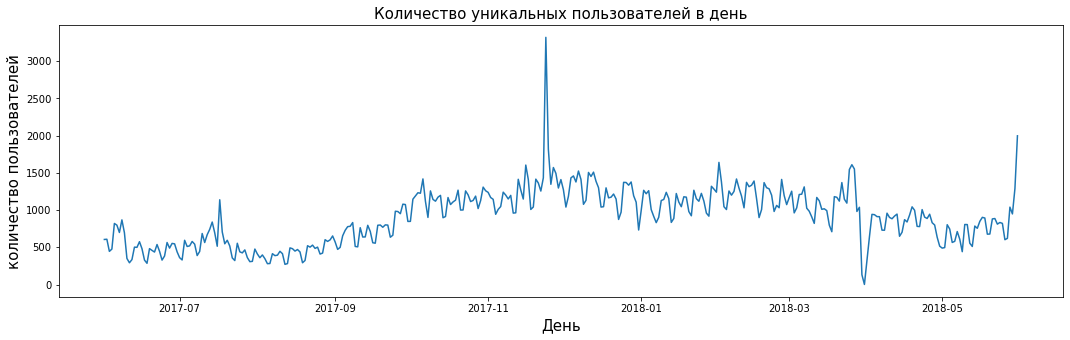

In [20]:
visits.groupby('session_day').agg({'uid':'nunique'}).plot(figsize=(18, 5));
plt.title('Количество уникальных пользователей в день', fontsize=15);
plt.xlabel('День', fontsize= 15)
plt.ylabel('количество пользователей', fontsize= 15) 
plt.legend('',frameon=False)
plt.show();

In [21]:
visits_activity = visits.copy(deep=True)
visits_activity['activity_month'] = visits_activity['session_day'].astype('datetime64[M]')
visits_activity['activity_week'] = visits_activity['session_day'].astype('datetime64[W]')
visits_activity['activity_day'] = visits_activity['session_day'].astype('datetime64[D]')


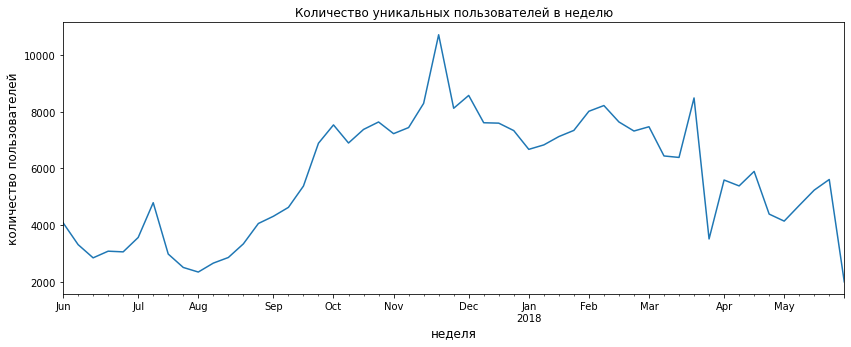

In [22]:
visits_activity.groupby('activity_week').agg({'uid':'nunique'}).plot(figsize=(14, 5));
plt.title('Количество уникальных пользователей в неделю', fontsize=12)
plt.ylim=(0,None)
plt.xlabel('неделя', fontsize= 12)
plt.ylabel('количество пользователей', fontsize= 12) 
plt.legend('',frameon=False)
plt.show();

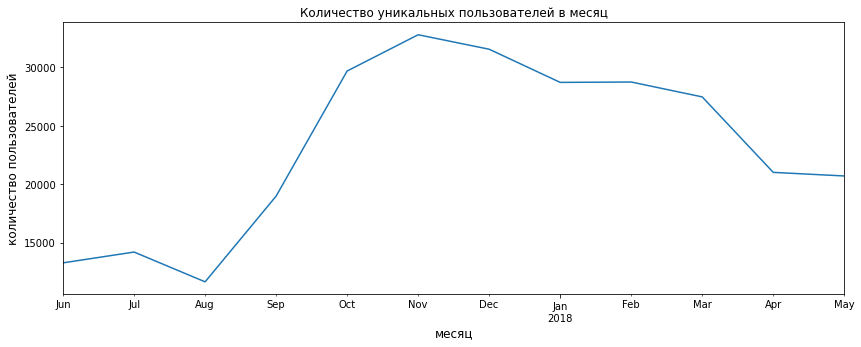

In [23]:
visits_activity.groupby('activity_month').agg({'uid':'nunique'}).plot(figsize=(14, 5));
plt.title('Количество уникальных пользователей в месяц', fontsize=12);
plt.xlabel('месяц', fontsize= 12)
plt.ylabel('количество пользователей', fontsize= 12) 
plt.legend('',frameon=False)
plt.show();

Мы получили количество пользователей, которое посещает сайт в день, в неделю, в месяц. Более 900 пользователей ежедневно. Стоит оценить эти параметры и понять, сколько пользователей действительно что-то покупают и каков % возврата.

##### Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени

Мы определили, что за день в среднем девятьсот восемь пользователей. Посмотрим, сколько в среднем сессий за день.

In [24]:
session_count = visits_activity.groupby('activity_day')['start_ts'].count()
print("Среднее количество сессий за день: {:.0f}".format(session_count.mean()))

Среднее количество сессий за день: 987


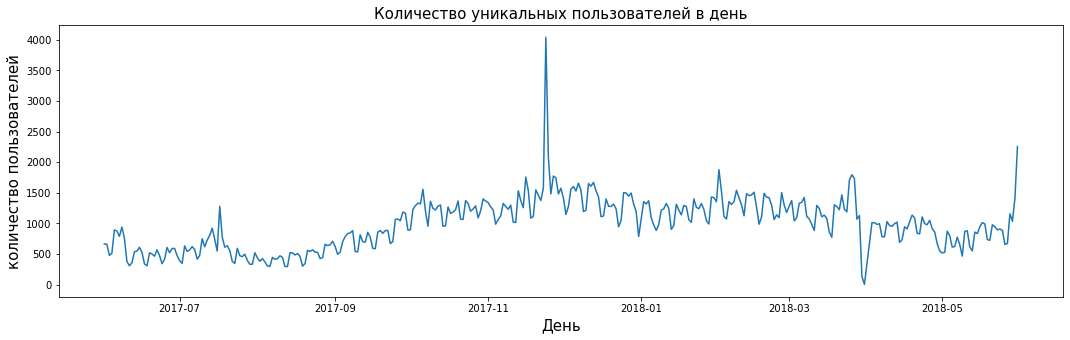

In [25]:
visits.groupby('session_day').agg({'uid':'count'}).plot(figsize=(18, 5));
plt.title('Количество уникальных пользователей в день', fontsize=15);
plt.xlabel('День', fontsize= 15)
plt.ylabel('количество пользователей', fontsize= 15) 
plt.legend('',frameon=False)
plt.show();

По графику заметно, что в конце ноября 2017 года был резкий скачок по количеству сессий, скорее всего это была черная пятница 24 ноября. А в конце марта 2018 что-то явно произошло на сайте. Можно поинтересватся у админов. 

In [26]:
# проверим предположение насчет черной пятницы
session_count.index = pd.to_datetime(session_count.index, format='%Y.%m.%d')
session_count['2017-11-24']

4042

Действительно, всплекс на графике - это черная пятница. 

Посчитаем среднее число сессий на одного пользователя за день

In [27]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [28]:
# сформируем вспомогательный dataFrame
# определим месяц и год сессии
visits_mean_session = visits[['uid', 'start_ts', 'session_day']]
visits_mean_session['visit_month'] = visits_mean_session.start_ts.apply(lambda x: x.strftime('%Y-%m'))

#добавим индекс в dataFrame по uid
visits_mean_session.set_index('uid', inplace=True) 

#переиндексируем dataFrame
visits_mean_session.reset_index(inplace=True) 

#создадим столбец n_visits в котором далее поместим количество визитов
visits_mean_session.insert(len(visits_mean_session.columns), 'n_visits', 0, allow_duplicates=False)

# Определим количество уникальных пользователей и общее количество визитов 
grouped_visits_mean_session = visits_mean_session.groupby(['visit_month', 'session_day'])
session_month_per_user = grouped_visits_mean_session.agg({'uid': pd.Series.nunique, 'n_visits': pd.Series.count})

# переименуем некоторые столбцы для удобства
session_month_per_user.rename(columns={'uid': 'n_users',
 'n_visits': 'n_visits'}, inplace=True)

session_month_per_user['visits_per_user'] = session_month_per_user['n_visits'] / session_month_per_user['n_users']

session_month_per_user.head()

n_users  n_visits  visits_per_user
visit_month session_day                                    
2017-06     2017-06-01       605       664         1.097521
            2017-06-02       608       658         1.082237
            2017-06-03       445       477         1.071910
            2017-06-04       476       510         1.071429
            2017-06-05       820       893         1.089024

In [29]:
print("Среднее значение сессий на пользователя в день: {:.2f}".format(session_month_per_user['visits_per_user'].mean()))

Среднее значение сессий на пользователя в день: 1.08


Один пользователь в среднем проводит в приложении 1 сессию в день. Не сказать, что продукт используется регулярно.

##### Продолжительность пользовательской сессии 

Определим длительность одной сессии: найдём ASL — посчитаем длину всех сессий и вычислим среднее.

In [30]:
asl = (visits['end_ts'] - visits['start_ts']).dt.seconds
asl.value_counts()


60       53029
0        35794
120      35748
180      26672
240      21085
         ...  
14880        1
18840        1
83640        1
20100        1
15660        1
Length: 312, dtype: int64

Чаще всего сессия длится 60 секунд. Построим распределение пользовательских сессий, чтобы правильно выбрать среднюю меру.

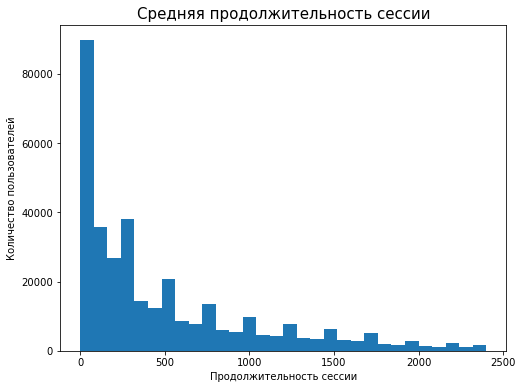

In [31]:
plt.figure(figsize=(8,6))
asl.hist(bins=30, range=(0, 2400), grid=False);
plt.title('Средняя продолжительность сессии', fontsize=15)
plt.xlabel('Продолжительность сессии', fontsize=10)
plt.ylabel('Количество пользователей', fontsize=10)
plt.show();

Так как распределение отличается от нормального, то для вычисления среднего расчитаем моду.

In [32]:
print("Средняя длительность сессии: {} секунд".format(asl.mode()[0]))

Средняя длительность сессии: 60 секунд


In [33]:
percent_60 = (asl.loc[asl == 60].count()/len(asl))
percent_0 = (asl.loc[asl == 0].count()/len(asl))
print("Процент сессий длительностью 60 секунд: {:.1%}".format(percent_60))
print("Процент сессий длительностью 0 секунд: {:.1%}".format(percent_0))      

Процент сессий длительностью 60 секунд: 14.8%
Процент сессий длительностью 0 секунд: 10.0%


Практически 15% сессий длится 60 секунд; также 10% сессий по 0 секунд говорят о каких то неполадках на сайте, возможно сессия нестабильна при входе с мобильных устройств.

##### Retention Rate

Мы определили, сколько посетителей на сайте каждый день, неделю, месяц. Посмотрим, как часто люди возвращаются.

In [34]:
# определим событие и период, сформируем когорты
# дата первой активности
first_activity_date = visits.groupby('uid')['session_day'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,2017-12-27


In [35]:
# выделим месяц из first_ativity_date и start_ts
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_day'].astype('datetime64[M]')

# выделим когорты
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month'])/ np.timedelta64(1,'M')
visits['cohort_lifetime'] = round(visits['cohort_lifetime']).astype('int')

# оставим в обозначении когорты только год и месяц
visits['first_activity_month'].dt.strftime('%d.%m.%Y') 
visits['first_activity_month'] = visits['first_activity_month'].dt.strftime('%Y-%m') 


Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый месяц.

In [36]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06,0,13259
1,2017-06,1,1043
2,2017-06,2,713
3,2017-06,3,814
4,2017-06,4,909
...,...,...,...
73,2018-03,1,861
74,2018-03,2,557
75,2018-04,0,15709
76,2018-04,1,760


In [37]:
# найдем исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count

,first_activity_month,cohort_users
0,2017-06,13259
12,2017-07,13140
23,2017-08,10181
33,2017-09,16704
42,2017-10,25977
50,2017-11,27248
57,2017-12,25268
63,2018-01,22624
68,2018-02,22197
72,2018-03,20589


In [38]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
# расчитаем Retention rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')


In [39]:
retention_pivot = retention_pivot.drop(columns=0)


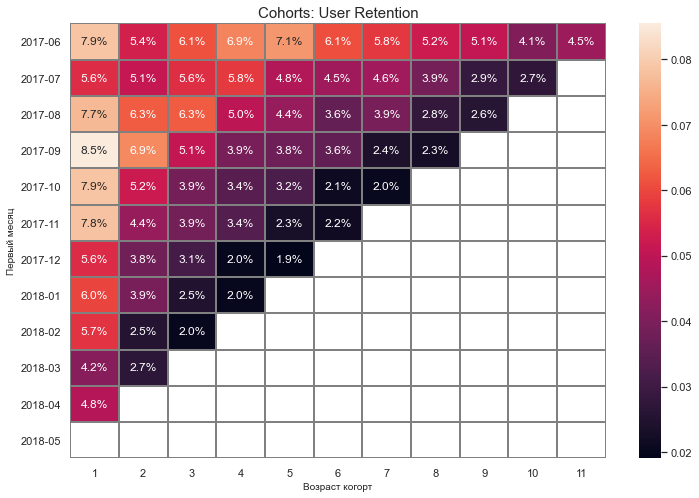

In [40]:
# построим тепловую карту 
sns.set(style='white')
plt.figure(figsize=(12,8))
plt.title('Cohorts: User Retention', fontsize=15)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 
plt.xlabel('Возраст когорт', fontsize=10)
plt.ylabel('Первый месяц', fontsize=10)
plt.show();

Найдем средний Retention Rate на второй месяц «жизни» когорт

In [41]:
retention_mean = retention_pivot.iloc[:, 0].mean()
print('средний Retention Rate = {:.2%}'.format(retention_mean)) 

средний Retention Rate = 6.52%


Похоже, Яндекс.Афиша не для постоянного пользования. Процент вернувшихся пользователей, в лучшем случае 7%. Видимо люди возвращаются пару раз и все. 

##### Вывод

В среднем ежедневно сайт посещают немногим более 900 новых пользователей, но возвращаются далеко не все. Однако, по графику Retention Rate, видно, что люди впервые посетившие сайт до осени 2017 показывают относительно высокий % возврата. Количество пользовательских сессий распредлено вполне плавно. Наблюдается плавный прирост к Новому году. Если осенью число сессий коллебалось от 500 до 1000, то в преддверии Нового года уже уверенно больше 1000. Оссобенно заметна всплеском на графике Черная пятница.

#### Метрики электронной коммерции.

##### Исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

In [42]:
# найдем дату первого посещения сайта
first_session_day = visits.groupby('uid')['start_ts'].min()
first_session_day.name = 'first_session_day'

# добавим информацию о первых визитах пользователей в таблицу с заказами
orders_ferst_visits = orders.merge(first_session_day, on='uid')
orders_ferst_visits.head()

,buy_ts,revenue,uid,first_session_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


In [43]:
# посчитаем количество дней до покупки
orders_ferst_visits['count_day'] = orders_ferst_visits['buy_ts'] - orders_ferst_visits['first_session_day']
orders_ferst_visits['count_day'] = orders_ferst_visits['count_day'].apply(lambda x: x.days)
orders_ferst_visits['count_day'].value_counts()
#orders.head()

0      28103
1       1422
2        837
3        628
4        532
       ...  
361        2
359        2
358        2
360        1
364        1
Name: count_day, Length: 365, dtype: int64

Построим распределение.

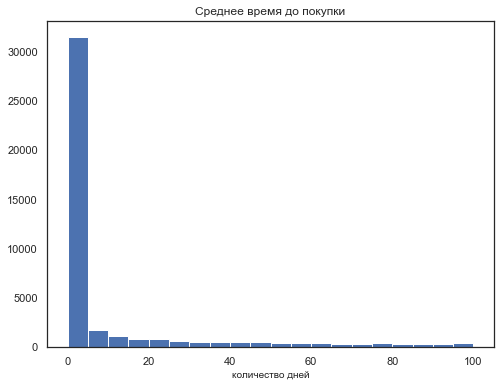

In [44]:
plt.figure(figsize=(8,6))
orders_ferst_visits['count_day'].hist(bins=20, range=(0, 100), grid=False)
plt.title('Среднее время до покупки', fontsize=12)
plt.xlabel('количество дней', fontsize=10)
plt.show();

Так как распределение отличается от нормального, то для вычисления среднего расчитаем моду.

In [45]:
print("Среднее время до покупки: {} дней".format(orders_ferst_visits['count_day'].mode()[0]))

Среднее время до покупки: 0 дней


Посмотрим, какое количество пользователей приобрели товар в тот же день, когда впервые зашли на сайт.

In [46]:
percent_0_days_buy = ((orders_ferst_visits['count_day'].loc[orders_ferst_visits['count_day'] == 0].count())/len(orders_ferst_visits['count_day']))

print("Купили товар сразу: {:.1%}".format(percent_0_days_buy))  

Купили товар сразу: 55.7%


Большинство пользователей совершают покупки в тот же день, когда впервые заходят на сайт. Но есть и такие, которым нужно время, чтобы подумать. 
Более половины покупателей совершенно точно знали, что им нужно. Остальные, скорее всего, сравнивали цены, кто-то думал, может вообще обойтись без этой покупки, но все-таки ее производил в конечном итоге.

##### Рассчитаем среднее количество покупок на одного покупателя за период.

In [47]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Построим когорты по средней частоте покупок:

Количество покупок за интервал / Количество уникальных клиентов. 

Построим тепловую карту по полученным данным.

In [48]:
data_mean_count = orders.copy(deep=True)

# Найдем дату первого заказа
first_order_dates = data_mean_count.groupby('uid')['buy_ts'].min()
first_order_dates.name = 'first_order_datetime'

# Присоединим к таблице с заказами
data_mean_count = data_mean_count.join(first_order_dates, on='uid', how='left', lsuffix='_left')

# Выделим месяц заказа и первый месяц и добавим в таблицу
data_mean_count['order_month'] = data_mean_count['buy_ts'].astype('datetime64[M]')
data_mean_count['first_order_month'] = data_mean_count['first_order_datetime'].astype('datetime64[M]')

first_orders = data_mean_count.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_ts']

first_visits = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_visits.columns = ['uid', 'first_visit_ts']

buyers = pd.merge(first_visits, first_orders, on='uid')
buyers['first_order_month'] = buyers['first_order_ts'].astype('datetime64[M]')

cohort_sizes_buyers = buyers.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes_buyers.rename(columns={'uid': 'n_buyers'}, inplace=True)

cohorts_buyers = pd.merge(data_mean_count, buyers, how='inner', on=['uid', 'first_order_month'])\
    .groupby(['first_order_month', 'order_month'])\
    .agg({'revenue': ['sum', 'count']}).reset_index()


In [49]:
# Считаем возраст каждой когорты
cohorts_buyers['age_month'] = ((cohorts_buyers['order_month'] - cohorts_buyers['first_order_month']) / np.timedelta64(1,'M'))
cohorts_buyers['age_month'] = cohorts_buyers['age_month'].round().astype('int')
cohorts_buyers.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']

In [50]:
# Добавляем в когортный отчет количество покупателей в каждой когорте 
# и считаем количество заказов на каждого покупателя.
cohorts_report = pd.merge(cohort_sizes_buyers, cohorts_buyers, on = 'first_order_month')
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']

In [51]:
# Возростной когортный отчет, показывающий накопительное количество заказов на покупателя
cohorts_age = cohorts_report.pivot_table(index='first_order_month', columns='age_month',
                                         values='orders_per_buyer', aggfunc='sum').cumsum(axis=1)

cohorts_age.fillna('')

age_month,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.83737,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07-01,1.136765,1.188768,1.25117,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,
2017-08-01,1.118978,1.19781,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.59708,,
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,,,
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.31129,1.335023,1.354839,1.383641,,,,
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.42073,1.445724,,,,,
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,,,,,,
2018-01-01,1.121554,1.187963,1.235102,1.254076,1.277201,,,,,,,
2018-02-01,1.121611,1.182416,1.205149,1.224322,,,,,,,,


Построим тепловую карту

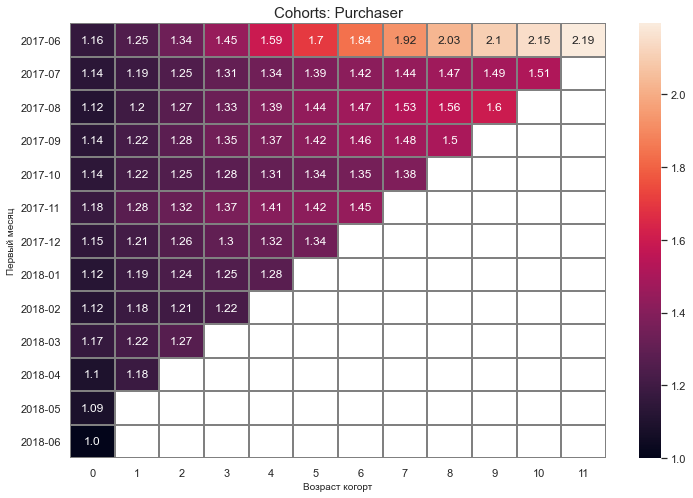

In [52]:
#cohorts_age.index = cohorts_age.index.strftime("%m/%Y")
sns.set(style='white')
plt.figure(figsize=(12,8))
plt.title('Cohorts: Purchaser', fontsize=15)
sns.heatmap(cohorts_age, annot=True, fmt='.3', linewidths=1, linecolor='gray', 
            yticklabels=cohorts_age.index.strftime('%Y-%m')); 
plt.xlabel('Возраст когорт', fontsize=10)
plt.ylabel('Первый месяц', fontsize=10)
plt.show();

In [53]:
print('Среднее количество покупок на уникального покупателя за 6 месяцев составляет:',  f'{cohorts_age[5].mean():.2f}')

Среднее количество покупок на уникального покупателя за 6 месяцев составляет: 1.43


##### Рассчитаем средний чек.

In [54]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [55]:
# Выделим месяцы и дни из дат в таблице с заказами:
orders['order_month'] = orders.buy_ts.apply(lambda x: x.strftime('%Y-%m'))
orders['session_day'] = orders.buy_ts.apply(lambda x: x.strftime('%Y-%m-%d'))
orders.head()

,buy_ts,revenue,uid,order_month,session_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01


Посчитаем средний чек в месяц, проведя группировку данных и построим график, отражающий изменения метрики во времени.

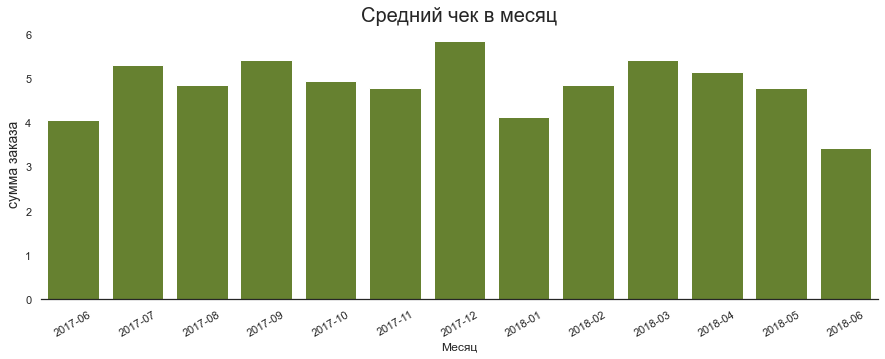

In [56]:
mean_purchase = orders.groupby('order_month')['revenue'].mean().reset_index()
mean_purchase['order_month']=mean_purchase['order_month'].astype('str')

plt.figure(figsize=(15, 5))
plt.title('Средний чек в месяц', fontsize=20)
sns.barplot(x='order_month', y='revenue', data=mean_purchase, color="olivedrab", label="line")
sns.despine(left=True)
plt.xlabel('Месяц')
plt.ylabel('сумма заказа', fontsize=14)
plt.xticks(rotation=30)
plt.show();

In [57]:
mean_purchase['revenue'].describe() 

count    13.000000
mean      4.838700
std       0.656336
min       3.420000
25%       4.771279
50%       4.847139
75%       5.306589
max       5.852139
Name: revenue, dtype: float64

Мы видим, что по месяцам средний чек отличается незначительно. Чаще всего покупают в декабре, что имеет однозначное объяснение - к Новому году объем продаж всегда возрастает. Летом покупают меньше, скорее всего, сказывается отпускной период.

In [58]:
print("Средний чек составил: {:.2f} у.е.".format(orders['revenue'].mean()))

Средний чек составил: 5.00 у.е.


##### Выясним, как меняется LTV на покупателя по когортам.

Для расчета LTV необходимо:
1.	найти дату первой покупки каждого покупателя;
2.	вычислить число новых покупателей за каждую дату;
3.	добавить дату первой покупки в таблицу с заказами;
4.	сгруппировать таблицу и посчитать выручку.


In [59]:
orders.head()

,buy_ts,revenue,uid,order_month,session_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06-01


In [60]:
orders['buy_ts'].describe() 

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [61]:
# Выделим месяцы из дат в таблице с заказами:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

# найдем дату первой покупки каждого покупателя 
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [62]:
# Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
cohort_sizes = (first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [63]:
# Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:
orders_new = pd.merge(orders,first_orders, on='uid')

# Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 
# Сбросим индекс методом reset_index():
cohorts = (orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'})
    .reset_index())

# Добавим в таблицу cohorts данные, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [64]:
# определим возраст каждой когорты 
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [65]:
# по условию маржинальность равна 100%, следовательно margin_rate = 1
# и валовая прибыль равна выручке
# найдём LTV 
# Разделим ввыручку когорт за каждый месяц на общее число пользователей в каждой когорте.
report['ltv'] = report['revenue'] / report['n_buyers']
report.head()

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


In [66]:
pivot_report = report.pivot_table(index='first_order_month', columns='age', values='ltv', 
                                  aggfunc='mean').round(2)
pivot_report_ltv = pivot_report.cumsum(axis = 1)
pivot_report_ltv.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5.0,5.93,7.0,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


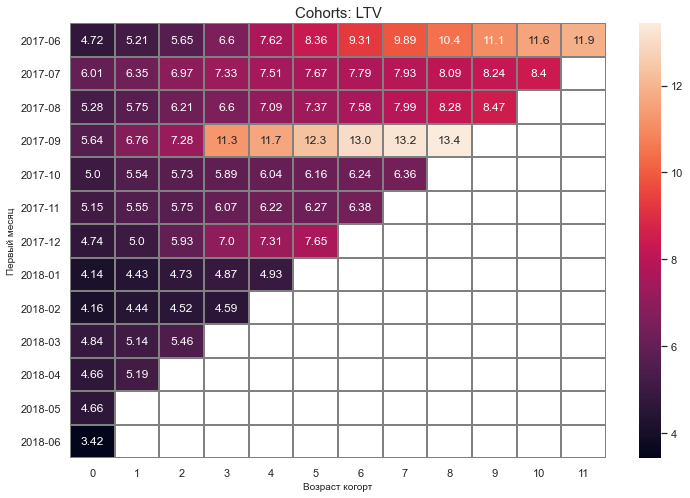

In [67]:
# построим тепловую карту 
sns.set(style='white')
plt.figure(figsize=(12,8))
plt.title('Cohorts: LTV', fontsize=15)
sns.heatmap(pivot_report_ltv, annot=True, fmt='.3', linewidths=1, linecolor='gray', 
            yticklabels=pivot_report_ltv.index.strftime('%Y-%m')); 
plt.xlabel('Возраст когорт', fontsize=10)
plt.ylabel('Первый месяц', fontsize=10)
plt.show();

В среднем при маржинальности 100% каждый покупатель из первой когорты принес около 12 у.е. выручки за 12 месяцев «жизни». Сентябрьская когорта превзошла такие показатели уже на шестом месяце.

Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев

In [68]:
# посмотрим, какие когорты "прожили" более 6 месяцев
pivot_report.cumsum(axis = 1).iloc[:,6:].fillna('')

age,6,7,8,9,10,11
first_order_month,,,,,,
2017-06-01,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,7.79,7.93,8.09,8.24,8.4,
2017-08-01,7.58,7.99,8.28,8.47,,
2017-09-01,13.01,13.25,13.43,,,
2017-10-01,6.24,6.36,,,,
2017-11-01,6.38,,,,,
2017-12-01,,,,,,
2018-01-01,,,,,,
2018-02-01,,,,,,


В расчет необходимо включить когорты с июня 2017 по ноябрь 2017. Их жизненный цикл более 6 месяцев.

In [69]:
df = pivot_report.cumsum(axis = 1).rename_axis(None, axis=1).reset_index()

# проведем отбор когорт, проживших более 6 месяцев 


In [70]:
df.iloc[0:6].fillna('')

,first_order_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
1,2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2,2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37,7.58,7.99,8.28,8.47,,
3,2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
4,2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
5,2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,


In [71]:
print('Средний LTV на 6-й месяц жизни когорты составляет:',  f'{df.iloc[0:6][5].mean():.2f}', 'у.е.')

Средний LTV на 6-й месяц жизни когорты составляет: 8.02 у.е.


##### Вывод

Проанализировав метрики электронной коммерции, можем сказать, что более половины покупалей точно знают, что они не случайно зашли на этот сайт, им не нужно время для принятия решения. Среднее время от первого визита до покупки составляет 0 дней.

Среднее количество покупок на уникального покупателя за 6 месяцев составляет: 1.43

Средний чек составил 5 у.е. 

Каждый покупатель из когорты июня 2017 года принес практически по 12 у.е. прибыли, а когорта сентября 2017 оказалась более прибыльной - 13.4 у.е.

Средний LTV на 6-й месяц жизни когорты составляет 8.02 у.е.

#### Маркетинговые метрики.

##### Дальше посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

In [72]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [73]:
# сумма расходов на маркетинг
marketing_sum = costs['costs'].sum()
print('Расходы на маркетинг составили:', marketing_sum)

Расходы на маркетинг составили: 329131.62


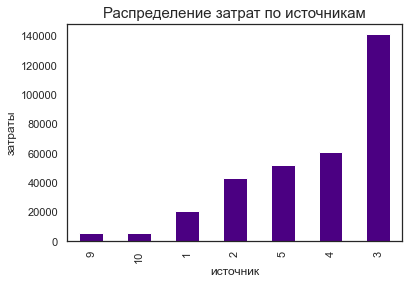

In [74]:
# посмотрим на распределение затрат по источникам
costs.groupby('source_id')['costs'].sum().sort_values().plot(kind='bar', color='indigo');
plt.title('Распределение затрат по источникам', fontsize=15);
#ax.tick_params(axis='both', labelsize=13)
plt.xlabel('источник', fontsize=12)
plt.ylabel('затраты', fontsize=12);


Из графического анализа видно, что наибольшие затраты произведены по источнику "3". Возможно, он является самым популярным.

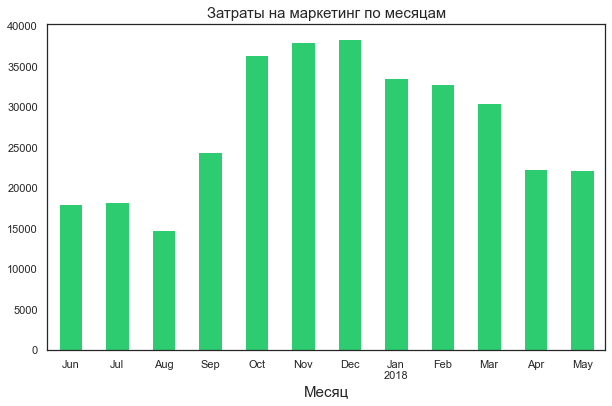

In [75]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
plt.title('Затраты на маркетинг по месяцам', fontsize=15);
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month
ax = costs.groupby('dt_month')['costs'].sum().plot(kind='bar', figsize=(10, 6), color='#2ecc71', rot=0)
ax.set_xticklabels(map(line_format, costs.groupby('dt_month')['costs'].sum().index));
plt.xlabel('Месяц', fontsize=15);

Похоже, что затраты увеличиватся под Новый год. Это логично, время покупать - а с хорошей рекламой купят еще больше

In [76]:
# сформируем сводную таблицу расходов по источникам
source_id_pivot = costs.pivot_table(index='dt_month', columns='source_id', values='costs', 
                                  aggfunc='sum')

Построим график динамики затрат по месяцам в разрезе источников

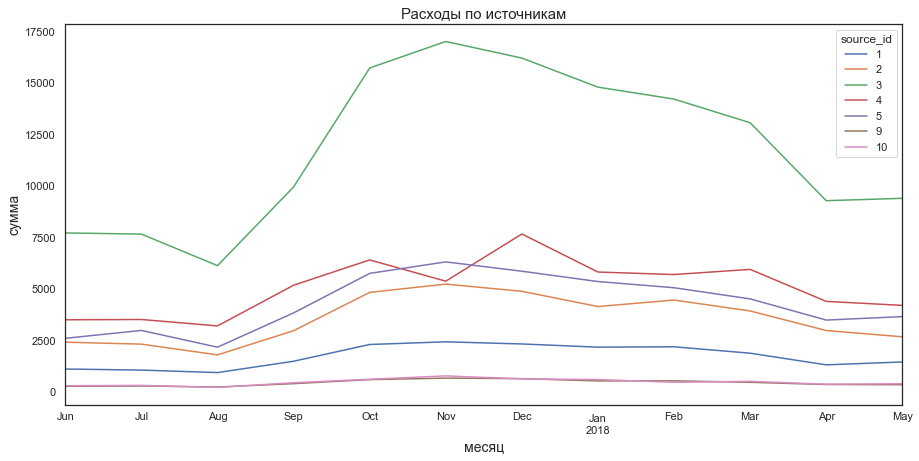

In [77]:
source_id_pivot.plot(figsize=(15, 7));
plt.title('Расходы по источникам', fontsize=15)
plt.xlabel('месяц', fontsize=14)
plt.ylabel('сумма', fontsize=14)
plt.show();

##### Рассчет CAC

Для расчета САС по каждому источнику найдем сначала LTV по каждому источнику.

In [78]:
# соединим таблицы visits и orders
user_orders = orders.merge(visits, how='left',on='uid')[['device','source_id','buy_ts','revenue','uid']]
user_orders.head()

,device,source_id,buy_ts,revenue,uid
0,desktop,1,2017-06-01 00:10:00,17.00,10329302124590727494
1,desktop,2,2017-06-01 00:25:00,0.55,11627257723692907447
2,desktop,2,2017-06-01 00:27:00,0.37,17903680561304213844
3,desktop,2,2017-06-01 00:29:00,0.55,16109239769442553005
4,desktop,3,2017-06-01 07:58:00,0.37,14200605875248379450


In [79]:
# найдем дату первой покупки для кадого пользователя
first_order_date = orders.groupby('uid')['buy_ts'].min() 
first_order_date.name = 'first_order_date'
user_orders = user_orders.join(first_order_date, on='uid')
user_orders.head()

,device,source_id,buy_ts,revenue,uid,first_order_date
0,desktop,1,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,desktop,2,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,desktop,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,desktop,2,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,desktop,3,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [80]:
user_orders['first_order_month'] = user_orders['first_order_date'].astype('datetime64[M]')
user_orders['order_month'] = user_orders['buy_ts'].astype('datetime64[M]')
user_orders.head()

,device,source_id,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,desktop,1,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,desktop,2,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,desktop,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,desktop,2,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,desktop,3,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [81]:
# определим источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})


# соединяем первые покупки и источники
sources_orders = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
sources_orders = sources_orders.rename(columns = {'buy_ts': 'first_order_date'})

sources_orders

,uid,first_order_date,source_id
0,313578113262317,2018-01-03 21:51:00,2
1,1575281904278712,2017-06-03 10:13:00,10
2,2429014661409475,2017-10-11 18:33:00,3
3,2464366381792757,2018-01-28 15:54:00,5
4,2551852515556206,2017-11-24 10:14:00,5
...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,5
36519,18445407535914413204,2017-09-22 23:55:00,3
36520,18445601152732270159,2018-03-26 22:54:00,2
36521,18446156210226471712,2018-02-18 19:34:00,3


In [82]:
# посчитаем LTV
ltv = sources_orders.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_order_date']) / np.timedelta64(1,'M')).round().astype(int)
ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)
cohort_sizes = sources_orders.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source_id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
ltv

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


Для первого источника LTV составило:

In [83]:
ltv_source_1 = ltv.loc[1].sum()
ltv_source_1

120.00676440151744

Посчитаем CAC для этой когорты

In [84]:
# посчитаем расходы за этот источник
costs_1 = costs[costs['source_id'] == 1]['costs'].sum()

n_buyers_1 = cohort_sizes.loc[1]
cac_source_1 = costs_1 / n_buyers_1
cac_source_1

cohort_size    7.186364
Name: 1, dtype: float64

Расходы на первый источник окупились. Посчитаем остальные когорты и посмотрим, сколько месяцев нужно каждой когорте, чтобы окупить маркетинговые затраты

In [85]:
# считаем расходы за каждый источник
source_costs = costs.groupby('source_id').sum()
source_costs

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


In [86]:
cac = source_costs.merge(cohort_sizes, on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


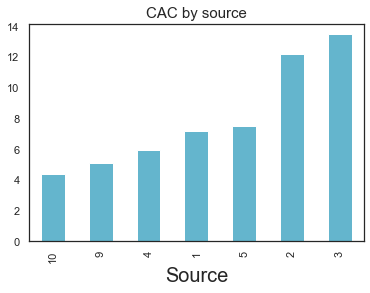

In [87]:
cac['cac'].sort_values().plot(kind='bar', color='c');

plt.title('CAC by source', fontsize=15);
ax.tick_params(axis='both', labelsize=13)
plt.xlabel('Source', fontsize=20);

Самыми дорогими с точки зрения привлечения являются клиенты из источников 2 и 3

In [88]:
# сформируем сводную таблицу расходов по источникам
source_id_pivot = costs.pivot_table(index='dt_month', columns='source_id', values='costs', 
                                  aggfunc='sum')
source_id_pivot.head()

source_id,1,2,3,4,5,9,10
dt_month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24


##### Расчитаем ROMI

In [89]:
romi = ltv.merge(cac[['cac']], on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
romi.cumsum(axis=1).round(2).fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.86,1.85,2.95,4.14,5.39,6.68,8.01,9.38,10.80,12.25,13.72,15.21,16.70
2,0.55,1.21,2.01,2.93,3.91,4.93,5.97,7.03,8.11,9.19,10.29,11.38,12.48
3,0.33,0.68,1.04,1.41,1.79,2.17,2.55,2.94,3.32,3.71,4.09,4.48,4.86
4,0.77,1.57,2.39,3.22,4.08,4.96,5.86,6.77,7.68,8.60,9.53,10.46,11.38
5,0.66,1.34,2.07,2.99,3.94,4.91,5.89,6.89,7.90,8.91,9.93,10.95,11.96
9,0.77,1.59,2.46,3.38,4.32,5.30,6.29,7.30,8.34,9.38,10.43,11.47,12.51
10,0.72,1.46,2.20,2.96,3.71,4.47,5.23,5.99,6.76,7.52,8.29,9.05,9.82


По отчету видно, что первая когорта окупилась почти сразу, на второй месяц. Реклама на 1 источнике весьма действенная. А вот 3,4 и 10 источники плохо окупаются, скорее всего либо перестали быть популярными и тут надо исследовать пользовательские категории либо вкладывать в рекламу на них нужно больше. 

##### Вывод

Исследования по маркетингу показали, сколько денег тратят маркетологи на каждый источник пользователей. посчитана стоимость привлечения пользователя из первого источника и показатель LTV превысол показатель CAC. Так что с этой точки зрения маркетинг действует правильно. Однако по графикам видно, что большие затраты идет на рекламу источника 3, но за весь рассматриваемые период эти затраты так и не вышли в плюс. Так что не стоит так упорно развивать 3 источник - это ни к чему не приведет. Лучше всего окупается 1 источник - уже через месяц компания получает прибыль. Источники 2, 9 и 5 окупаются лишь на 5, 6 и 7 месяц соответственно - тут явно сработало увеличение вложений в рекламу с октября по декабрь. А вот источники 3 и 4 вовсе не окупились. 

### Общий вывод

На основании проведенного анализа, отделу маркетинга можно дать следующие рекомендации:

перераспределить бюджет по источникам. Сейчас практически половина бюждета выделена на канал, который приносит самых дорогих клиентов и имеет самый низкий ROMI по сравнению с остальными каналами. На основании стоимости привлечения покупателя можно выделить источник №4 как наиболее перспективный. Он показывает хорошие показатели при сравнительно высоком бюджете, то есть он уже достаточно масштабирован, чтобы делать выводы. Этот источник приводит больше покупателей, чем №3 (на который уходит большая часть бюджета) и при этом расходы на канал №4 в два раза меньше, чем на №3.

по показателю ROMI абсолбтно точно стоит увеличить бюджет на канал №1, а также масштабировать канал №2, но принимать во внимание высокую стоимость привлечения клиентов.



В среднем ежедневно сайт посещают немногим более 900 новых пользователей, но возвращаются далеко не все. Однако, по графику Retention Rate, видно, что люди впервые посетившие сайт до осени 2017 показывают относительно высокий % возврата. Количество пользовательских сессий распредлено вполне плавно. Наблюдается плавный прирост к Новому году.

Проанализировав метрики электронной коммерции, можем сказать, что более половины покупалей точно знают, что они не случайно зашли на этот сайт, им не нужно время для принятия решения. Среднее время от первого визита до покупки составляет 0 дней.

Среднее количество покупок на уникального покупателя за 6 месяцев составляет: 1.43

Средний чек составил 5 у.е.

Каждый покупатель из когорты июня 2017 года принес практически по 12 у.е. прибыли, а когорта сентября 2017 оказалась более прибыльной - 13.4 у.е.

Средний LTV на 6-й месяц жизни когорты составляет 8.02 у.е.

По итогам когортного анализа можно с уверенносью сказать, что самые перспективные для компании оказались когорты июня и сентября 2017 года.